In [71]:
import torch
import torch.nn.functional as F
from sklearn.model_selection import KFold
import numpy as np
import copy

import os
import sys
import pathlib
pth=str(pathlib.Path().absolute())

#Utilities
sys.path.append(pth)
from model_An import *
from util import *
from Data_loader_image import *

#Base de datos
#sys.path.append()
#data=("/").join(pth.split("/")[:-2])+"/Data_Base/Metada_V6G_p1"
data=("/").join(pth.split("/")[:-2])+"/Data_Base/Metadata_V7G_pytorch"
data_arg=("/").join(pth.split("/")[:-2])+"/Data_Base"


In [79]:
#dataset=Rotated_Dataset(data_arg,"Metadata_V6G_p1")
dataset=Rotated_Dataset(data_arg,"Metadata_V10G_pytorch",
                        features=[
                            12,
                            13,
                            15,
                            16,
                            -5,
                            -4,
                            -3,
                            -2,
                            -1,
                        ],
                        range=[0,50]
                       )

In [83]:
Y=np.sort(np.unique(dataset.landmarks_frame[:,1].astype(float)))
Y=dataset.landmarks_frame[:,1].astype(float)

[ 8.9  9.4  9.6  9.7  9.8  9.9 10.  10.2 10.3 10.4 10.5 10.6 10.7 10.8
 10.9 11.  11.1 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1 12.2
 12.3 12.4 12.5 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6
 13.7 13.8 13.9 14.  14.1 14.2 14.3 14.4 14.5 14.7 14.9 15.9]
[ 16  13  16  16  16  32  16  16  32  24  48  40  80  32  57  16 120 144
  56  56 128 118  87 152 136 112 232 192  72  88 136 208 113 152 240 130
 160 112  58  40  40  24  56  56  48  24   8  24  16  16  32  24   8  16]


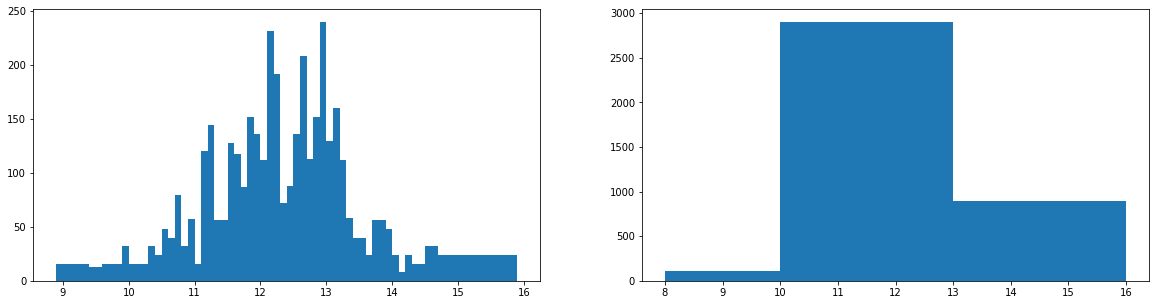

In [ ]:
Yc=np.sort(np.unique(Y.astype(float)))
np.sum(Y.astype(float)==Yc[0])
Yd=np.vectorize(lambda Y,Yc:np.sum(Y.astype(float)==Yc),signature="(j),()->()")(Y,Yc)
print(Yc)
print(Yd)

import matplotlib.pyplot as plt
fig,axs=plt.subplots(1,2,figsize=(20,5))
axs[0].hist(Y.astype(float),Yc)
axs[1].hist(Y.astype(float),[8,10,13,16])
plt.show()

In [95]:
print(np.sum(Yd))
print(np.sum(np.logical_or(Yc<10,Yc>14).astype(float)*Yd))
100*(np.sum(np.logical_or(Yc<10,Yc>14).astype(float)*Yd)/np.sum(Yd))

3904
253.0


6.480532786885246

In [67]:
set([0,1,2,3,4,5]).substract([0,5])

AttributeError: 'set' object has no attribute 'substract'

In [3]:
np.unique(dataset.landmarks_frame[:,1])

array(['10.0', '10.1', '10.2', '10.3', '10.4', '10.5', '10.6', '10.7',
       '10.8', '10.9', '11.0', '11.1', '11.2', '11.3', '11.4', '11.5',
       '11.6', '11.7', '11.8', '11.9', '12.0', '12.1', '12.2', '12.3',
       '12.4', '12.5', '12.6', '12.7', '12.8', '12.9', '13.0', '13.1',
       '13.2', '13.3', '13.4', '13.5', '13.6', '13.7', '13.8', '13.9',
       '14.0', '14.1', '14.2', '14.3', '14.4', '14.5', '14.6', '14.7',
       '14.9', '8.3', '8.9', '9.4', '9.6', '9.7', '9.8', '9.9'],
      dtype='<U23')

In [2]:
ls

best0.pt                           MMhh_n_0/
best1.pt                           MMhh_n_L1/
best2.pt                           MMhh_SelFR_Bin2Cl/
best3.pt                           MMhh_SelFR_L2_4Cl/
best4.pt                           MMhh_SelFR_v10_BinCl/
best5.pt                           MMhh_SelFR_v10_BinCl2/
best6.pt                           MMhh_SelFR_v10_BinCl3/
best7.pt                           MMhh_SelFR_v10_BinCl4/
best8.pt                           MMhh_SelFR_v8_4Cl/
best9.pt                           MMhh_SelFR_v8_BinCl/
Data_loader_image.py               MMhh_Sel_L1/
Data_loader_meta.py                MMhh_Sel_L2/
hh_n_0/                            MMhh_Sel_L2_10Cl/
last0.pt                           MMhh_Sel_L2_Cl/
last1.pt                           MMhh_Sel_v8_10Cl/
last2.pt                           MMhh_Sel_v8_StCl/
last3.pt                           model_An.py
last4.pt                           model.py
last5.pt                           prototype.py
last6.pt       

In [64]:
os.listdir()
res_dir="MMhh_SelFR_v10_BinCl2"

lr=np.load(os.path.join(pth,res_dir,'last_results_10f_unsampled_hh.npy'),allow_pickle=True)

lra=np.load(os.path.join(pth,res_dir,'last_results_abs_10f_unsampled_hh.npy'),allow_pickle=True)

lspe=np.load(os.path.join(pth,res_dir,'last_results_specificity_10f_unsampled_hh.npy'),allow_pickle=True)
lsen=np.load(os.path.join(pth,res_dir,'last_results_sensitivity_10f_unsampled_hh.npy'),allow_pickle=True)
lTP=np.load(os.path.join(pth,res_dir,'last_results_TP_10f_unsampled_hh.npy'),allow_pickle=True)
lTN=np.load(os.path.join(pth,res_dir,'last_results_TN_10f_unsampled_hh.npy'),allow_pickle=True)
lFN=np.load(os.path.join(pth,res_dir,'last_results_FN_10f_unsampled_hh.npy'),allow_pickle=True)
lFP=np.load(os.path.join(pth,res_dir,'last_results_FP_10f_unsampled_hh.npy'),allow_pickle=True)

In [65]:
v_a=np.vectorize(lambda d,i:np.array(d[i]["valid_acc"]),signature="(),()->(j)")(lr.reshape(1,)[0],
                                                     np.array(list(lr.reshape(1,)[0].keys())))
t_a=np.vectorize(lambda d,i:np.array(d[i]["train_loss"]),signature="(),()->(j)")(lr.reshape(1,)[0],
                                                     np.array(list(lr.reshape(1,)[0].keys())))

vv_a=np.vstack((np.max(v_a,axis=0),
                np.min(v_a,axis=0),
                np.mean(v_a,axis=0),
                np.mean(v_a,axis=0)+np.std(v_a,axis=0),
                np.mean(v_a,axis=0)-np.std(v_a,axis=0)
               ))
tt_a=np.vstack((np.max(t_a,axis=0),
                np.min(t_a,axis=0),
                np.mean(t_a,axis=0),
                np.mean(t_a,axis=0)+np.std(t_a,axis=0),
                np.mean(t_a,axis=0)-np.std(t_a,axis=0)
              ))


v_a=np.vectorize(lambda d,i:np.array(d[i]["valid_acc_abs"]),signature="(),()->(j)")(lra.reshape(1,)[0],
                                                     np.array(list(lra.reshape(1,)[0].keys())))
t_a=np.vectorize(lambda d,i:np.array(d[i]["train_acc_abs"]),signature="(),()->(j)")(lra.reshape(1,)[0],
                                                     np.array(list(lra.reshape(1,)[0].keys())))

vv_aa=np.vstack((np.max(v_a,axis=0),
                np.min(v_a,axis=0),
                np.mean(v_a,axis=0),
                np.mean(v_a,axis=0)+np.std(v_a,axis=0),
                np.mean(v_a,axis=0)-np.std(v_a,axis=0)
               ))
tt_aa=np.vstack((np.max(t_a,axis=0),
                np.min(t_a,axis=0),
                np.mean(t_a,axis=0),
                np.mean(t_a,axis=0)+np.std(t_a,axis=0),
                np.mean(t_a,axis=0)-np.std(t_a,axis=0)
              ))

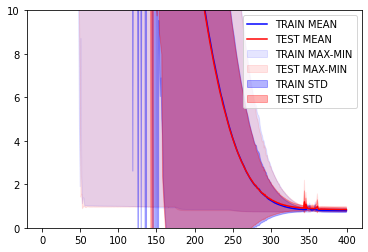

In [66]:

import matplotlib.pyplot as plt
    
init=0
end=400
plt.fill_between(x=np.arange(tt_a[1][init:end].shape[0]),y1=tt_a[1][init:end],y2=tt_a[0][init:end],color='b',alpha=0.1, label = "TRAIN MAX-MIN")
plt.fill_between(x=np.arange(tt_a[1][init:end].shape[0]),y1=vv_a[1][init:end],y2=vv_a[0][init:end],color='r',alpha=0.1, label = "TEST MAX-MIN")

plt.fill_between(x=np.arange(tt_a[1][init:end].shape[0]),y1=tt_a[3][init:end],y2=tt_a[4][init:end],color='b',alpha=0.3, label = "TRAIN STD")
plt.fill_between(x=np.arange(tt_a[1][init:end].shape[0]),y1=vv_a[3][init:end],y2=vv_a[4][init:end],color='r',alpha=0.3, label = "TEST STD")

plt.plot(tt_a[2][init:end],'b', label = "TRAIN MEAN")
plt.plot(vv_a[2][init:end],'r', label = "TEST MEAN")

plt.ylim(0,10)
plt.legend()
plt.show()

In [67]:
print(vv_a[2].min())
print(np.argmin(vv_a[2]))
vv_a[3][np.argmin(vv_a[2])]-vv_a[2].min()

0.8099668202190136
421


0.06924395544642359

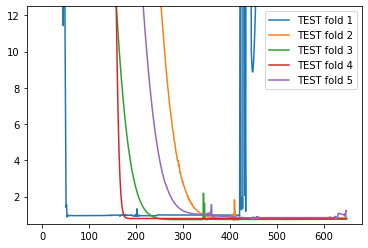

In [68]:
import matplotlib.pyplot as plt



for f in list(lr.reshape(1,)[0].keys()):

    plt.plot(lr.reshape(1,)[0][f]["valid_acc"], label = "TEST fold "+str(f+1))
    
plt.ylim(0.5,12.5)
plt.legend()
plt.show()

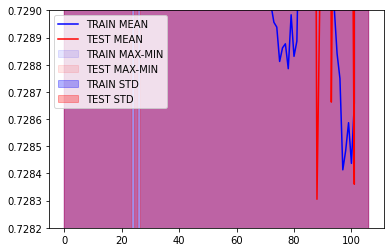

In [69]:
import matplotlib.pyplot as plt
    
init=320
end=427
plt.fill_between(x=np.arange(tt_aa[1][init:end].shape[0]),y1=tt_aa[1][init:end],y2=tt_aa[0][init:end],color='b',alpha=0.1, label = "TRAIN MAX-MIN")
plt.fill_between(x=np.arange(tt_aa[1][init:end].shape[0]),y1=vv_aa[1][init:end],y2=vv_aa[0][init:end],color='r',alpha=0.1, label = "TEST MAX-MIN")

plt.fill_between(x=np.arange(tt_aa[1][init:end].shape[0]),y1=tt_aa[3][init:end],y2=tt_aa[4][init:end],color='b',alpha=0.3, label = "TRAIN STD")
plt.fill_between(x=np.arange(tt_aa[1][init:end].shape[0]),y1=vv_aa[3][init:end],y2=vv_aa[4][init:end],color='r',alpha=0.3, label = "TEST STD")

plt.plot(tt_aa[2][init:end],'b', label = "TRAIN MEAN")
plt.plot(vv_aa[2][init:end],'r', label = "TEST MEAN")

plt.ylim(0.7282,0.729)
plt.legend()
plt.show()

In [70]:
print(vv_aa[2].min())
print(np.argmin(vv_aa[2]))
vv_aa[3][np.argmin(vv_aa[2])]-vv_aa[2].min()

0.7283049459148387
408


0.03207150402766856

In [92]:
#(folds,epochs,classes)
flTP_v=np.vectorize(lambda lTP,i:np.array(lTP[i]['valid_acc_abs']),
             signature="(),()->(j,i)")(lTP.reshape(1,)[0],np.array(list(lTP.reshape(1,)[0].keys())))*1
flTN_v=np.vectorize(lambda lTP,i:np.array(lTP[i]['valid_acc_abs']),
             signature="(),()->(j,i)")(lTN.reshape(1,)[0],np.array(list(lTN.reshape(1,)[0].keys())))*1
flFP_v=np.vectorize(lambda lTP,i:np.array(lTP[i]['valid_acc_abs']),
             signature="(),()->(j,i)")(lFP.reshape(1,)[0],np.array(list(lFP.reshape(1,)[0].keys())))*1
flFN_v=np.vectorize(lambda lTP,i:np.array(lTP[i]['valid_acc_abs']),
             signature="(),()->(j,i)")(lFN.reshape(1,)[0],np.array(list(lFN.reshape(1,)[0].keys())))*1

flsen_v=np.vectorize(lambda lTP,i:np.array(lTP[i]['valid_acc_abs']),
             signature="(),()->(j,i)")(lFN.reshape(1,)[0],np.array(list(lsen.reshape(1,)[0].keys())))*1

flspe_v=np.vectorize(lambda lTP,i:np.array(lTP[i]['valid_acc_abs']),
             signature="(),()->(j,i)")(lFN.reshape(1,)[0],np.array(list(lspe.reshape(1,)[0].keys())))*1

In [93]:
#(folds,epochs,classes)
flTP_t=np.vectorize(lambda lTP,i:np.array(lTP[i]['train_acc_abs']),
             signature="(),()->(j,i)")(lTP.reshape(1,)[0],np.array(list(lTP.reshape(1,)[0].keys())))*1
flTN_t=np.vectorize(lambda lTP,i:np.array(lTP[i]['train_acc_abs']),
             signature="(),()->(j,i)")(lTN.reshape(1,)[0],np.array(list(lTN.reshape(1,)[0].keys())))*1
flFP_t=np.vectorize(lambda lTP,i:np.array(lTP[i]['train_acc_abs']),
             signature="(),()->(j,i)")(lFP.reshape(1,)[0],np.array(list(lFP.reshape(1,)[0].keys())))*1
flFN_t=np.vectorize(lambda lTP,i:np.array(lTP[i]['train_acc_abs']),
             signature="(),()->(j,i)")(lFN.reshape(1,)[0],np.array(list(lFN.reshape(1,)[0].keys())))*1

flsen_t=np.vectorize(lambda lTP,i:np.array(lTP[i]['train_acc_abs']),
             signature="(),()->(j,i)")(lFN.reshape(1,)[0],np.array(list(lsen.reshape(1,)[0].keys())))*1

flspe_t=np.vectorize(lambda lTP,i:np.array(lTP[i]['train_acc_abs']),
             signature="(),()->(j,i)")(lFN.reshape(1,)[0],np.array(list(lspe.reshape(1,)[0].keys())))*1

In [94]:
fsen_v=flTP_v/(flTP_v+flFN_v)
fspe_v=flTN_v/(flFP_v+flTN_v)
acccl_v=(flTN_v+flTP_v)/(flFP_v+flFN_v+flTN_v+flTP_v)

fsen_t=flTP_t/(flTP_t+flFN_t)
fspe_t=flTN_t/(flFP_t+flTN_t)
acccl_t=(flTN_t+flTP_t)/(flFP_t+flFN_t+flTN_t+flTP_t)

<ipython-input-94-2d33aefb341b>:2: RuntimeWarning: invalid value encountered in true_divide
  fspe_v=flTN_v/(flFP_v+flTN_v)
<ipython-input-94-2d33aefb341b>:6: RuntimeWarning: invalid value encountered in true_divide
  fspe_t=flTN_t/(flFP_t+flTN_t)


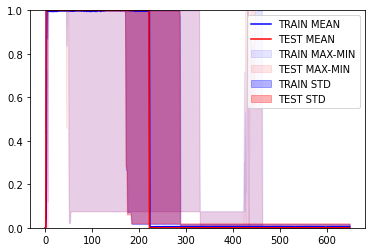

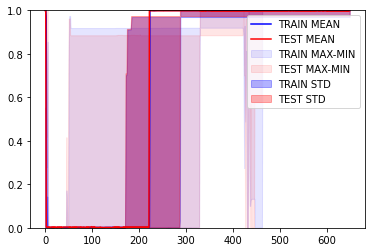

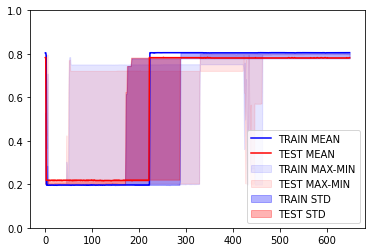

In [95]:
import matplotlib.pyplot as plt
cl=2
tt_aa=fsen_t[:,:,cl]
vv_aa=fsen_v[:,:,cl]
init=0
plt.fill_between(x=np.arange(tt_aa[1][init:].shape[0]),y1=tt_aa[1][init:],y2=tt_aa[0][init:],color='b',alpha=0.1, label = "TRAIN MAX-MIN")
plt.fill_between(x=np.arange(tt_aa[1][init:].shape[0]),y1=vv_aa[1][init:],y2=vv_aa[0][init:],color='r',alpha=0.1, label = "TEST MAX-MIN")

plt.fill_between(x=np.arange(tt_aa[1][init:].shape[0]),y1=tt_aa[3][init:],y2=tt_aa[4][init:],color='b',alpha=0.3, label = "TRAIN STD")
plt.fill_between(x=np.arange(tt_aa[1][init:].shape[0]),y1=vv_aa[3][init:],y2=vv_aa[4][init:],color='r',alpha=0.3, label = "TEST STD")

plt.plot(tt_aa[2][init:],'b', label = "TRAIN MEAN")
plt.plot(vv_aa[2][init:],'r', label = "TEST MEAN")

plt.ylim(0,1)
plt.legend()
plt.show()

tt_aa=fspe_t[:,:,cl]
vv_aa=fspe_v[:,:,cl]
    
init=0
plt.fill_between(x=np.arange(tt_aa[1][init:].shape[0]),y1=tt_aa[1][init:],y2=tt_aa[0][init:],color='b',alpha=0.1, label = "TRAIN MAX-MIN")
plt.fill_between(x=np.arange(tt_aa[1][init:].shape[0]),y1=vv_aa[1][init:],y2=vv_aa[0][init:],color='r',alpha=0.1, label = "TEST MAX-MIN")

plt.fill_between(x=np.arange(tt_aa[1][init:].shape[0]),y1=tt_aa[3][init:],y2=tt_aa[4][init:],color='b',alpha=0.3, label = "TRAIN STD")
plt.fill_between(x=np.arange(tt_aa[1][init:].shape[0]),y1=vv_aa[3][init:],y2=vv_aa[4][init:],color='r',alpha=0.3, label = "TEST STD")

plt.plot(tt_aa[2][init:],'b', label = "TRAIN MEAN")
plt.plot(vv_aa[2][init:],'r', label = "TEST MEAN")

plt.ylim(0,1)
plt.legend()
plt.show()

tt_aa=acccl_t[:,:,cl]
vv_aa=acccl_v[:,:,cl]
    
init=0
plt.fill_between(x=np.arange(tt_aa[1][init:].shape[0]),y1=tt_aa[1][init:],y2=tt_aa[0][init:],color='b',alpha=0.1, label = "TRAIN MAX-MIN")
plt.fill_between(x=np.arange(tt_aa[1][init:].shape[0]),y1=vv_aa[1][init:],y2=vv_aa[0][init:],color='r',alpha=0.1, label = "TEST MAX-MIN")

plt.fill_between(x=np.arange(tt_aa[1][init:].shape[0]),y1=tt_aa[3][init:],y2=tt_aa[4][init:],color='b',alpha=0.3, label = "TRAIN STD")
plt.fill_between(x=np.arange(tt_aa[1][init:].shape[0]),y1=vv_aa[3][init:],y2=vv_aa[4][init:],color='r',alpha=0.3, label = "TEST STD")

plt.plot(tt_aa[2][init:],'b', label = "TRAIN MEAN")
plt.plot(vv_aa[2][init:],'r', label = "TEST MEAN")

plt.ylim(0,1)
plt.legend()
plt.show()

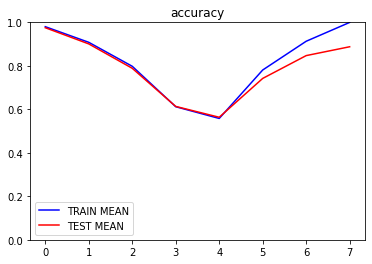

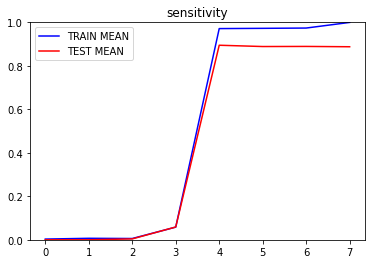

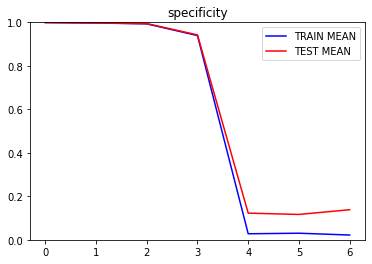

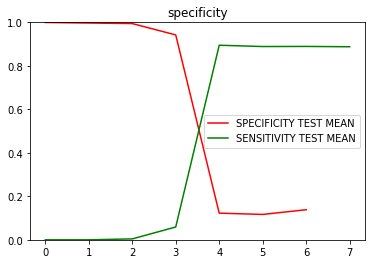

In [96]:
plt.title("accuracy")
plt.plot(np.mean(acccl_t[:,-1,:],axis=0),'b', label = "TRAIN MEAN")
plt.plot(np.mean(acccl_v[:,-1,:],axis=0),'r', label = "TEST MEAN")

plt.ylim(0,1)
plt.legend()
plt.show()


plt.title("sensitivity")
plt.plot(np.mean(fsen_t[:,-1,:],axis=0),'b', label = "TRAIN MEAN")
plt.plot(np.mean(fsen_v[:,-1,:],axis=0),'r', label = "TEST MEAN")

plt.ylim(0,1)
plt.legend()
plt.show()

plt.title("specificity")
plt.plot(np.mean(fspe_t[:,-1,:],axis=0),'b', label = "TRAIN MEAN")
plt.plot(np.mean(fspe_v[:,-1,:],axis=0),'r', label = "TEST MEAN")

plt.ylim(0,1)
plt.legend()
plt.show()

plt.title("specificity")
plt.plot(np.mean(fspe_v[:,-1,:],axis=0),'r', label = "SPECIFICITY TEST MEAN")
plt.plot(np.mean(fsen_v[:,-1,:],axis=0),'g', label = "SENSITIVITY TEST MEAN")

plt.ylim(0,1)
plt.legend()
plt.show()

#np.array([[10,11],[11,12],[12,13],[13,14]])

In [36]:
(fspe_v+fsen_v).shape

(5, 550, 8)

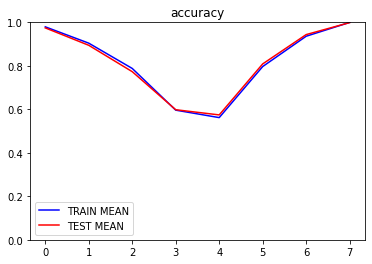

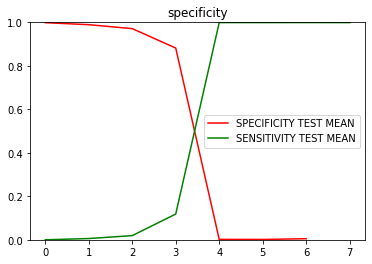

In [99]:
epoch=400
plt.title("accuracy")
plt.plot(np.mean(acccl_t[:,epoch,:],axis=0),'b', label = "TRAIN MEAN")
plt.plot(np.mean(acccl_v[:,epoch,:],axis=0),'r', label = "TEST MEAN")

plt.ylim(0,1)
plt.legend()
plt.show()

plt.title("specificity")
plt.plot(np.mean(fspe_v[:,epoch,:],axis=0),'r', label = "SPECIFICITY TEST MEAN")
plt.plot(np.mean(fsen_v[:,epoch,:],axis=0),'g', label = "SENSITIVITY TEST MEAN")

plt.ylim(0,1)
plt.legend()
plt.show()

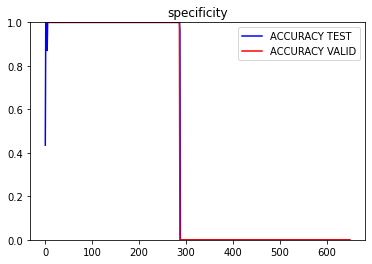

In [100]:
acccl_t[1,:,1]

plt.title("specificity")
plt.plot(fsen_t[4,:,2],'b', label = "ACCURACY TEST")
plt.plot(fsen_v[4,:,2],'r', label = "ACCURACY VALID")

plt.ylim(0,1)
plt.legend()
plt.show()